# Advanced Machine Learning - Final Project

### Importing and Cleaning the Data

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, \
  Embedding, TextVectorization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [98]:
train_data, test_data = tfds.load(
  'ag_news_subset',
  split = ['train', 'test'],
  batch_size = -1
)
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

In [99]:
df_train.head()

,description,label,title
0,b'AMD #39;s new dual-core Opteron chip is desi...,3,b'AMD Debuts Dual-Core Opteron Processor'
1,b'Reuters - Major League Baseball\\Monday anno...,1,"b""Wood's Suspension Upheld (Reuters)"""
2,b'President Bush #39;s quot;revenue-neutral q...,2,b'Bush reform may have blue states seeing red'
3,b'Britain will run out of leading scientists u...,3,"b""'Halt science decline in schools'"""
4,"b'London, England (Sports Network) - England m...",1,b'Gerrard leaves practice'


We can see from the examples that we will need to clean the text before we can use it. The 'b' at the beginning of each line means that it is in byte form, not string form.  Additionally, we see that 39

In [100]:
def clean_text(df, column):
    for i, text in enumerate(df[column]):
        if isinstance(text, bytes):
            text = text.decode('utf-8', errors='ignore')

        # Replace the '#39's with apostrophes
        text = text.replace("#39;", "'")
        # For simplicity, make everything lowercase
        text = text.lower()
        # Only keep letters, numbers, and punctuation
        text = re.sub(r"[^a-z0-9.?!' ]+", " ", text)
        # Remove leading and trailing apostrophes
        text = text.strip("'")
        # Keep possessive apostrophes
        clean = re.sub(r"\s+'", "'", text)
        df.at[i, column] = clean

    return df

In [101]:
clean_text(df_train, "description")
clean_text(df_train, "title")
df_train.head()

,description,label,title
0,amd's new dual core opteron chip is designed m...,3,amd debuts dual core opteron processor
1,reuters major league baseball monday announc...,1,wood's suspension upheld reuters
2,president bush's quot revenue neutral quot t...,2,bush reform may have blue states seeing red
3,britain will run out of leading scientists unl...,3,halt science decline in schools
4,london england sports network england mid...,1,gerrard leaves practice


In [102]:
clean_text(df_test, "description")
clean_text(df_test, "title")
df_test.head()

,description,label,title
0,charlotte n.c. sports network carolina p...,1,carolina's davis done for the season
1,presentacion philippines reuters philipp...,0,philippine rebels free troops talks in doubt
2,san francisco ca november 30 2004 ubisoft...,3,new rainbow six franchise for spring 2005
3,daniel vettori spun new zealand to the brink o...,1,kiwis heading for big win
4,afp georgian and south ossetian forces overn...,0,shelling shooting resumes in breakaway georgi...


### Exploratory Data Analysis

(array([30000.,     0.,     0., 30000.,     0.,     0., 30000.,     0.,
            0., 30000.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

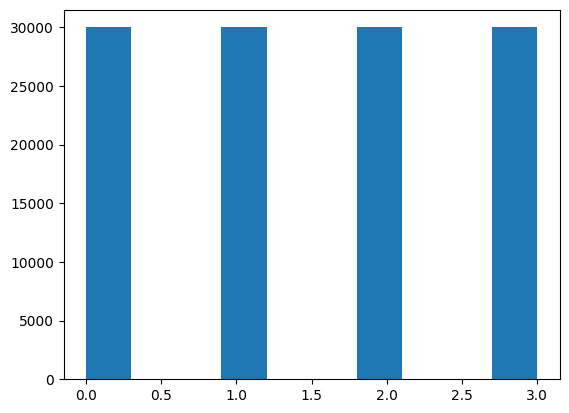

In [110]:
plt.hist(df_train['label'])

### Preparing the Data

In [103]:
desc_train = df_train['description']
title_train = df_train['title']
label_train = to_categorical(df_train['label'])

desc_test = df_test['description']
title_test = df_test['title']
label_test = to_categorical(df_test['label'])

### Creating the Classifier

In [104]:
max_tokens = 1000
max_sequence_length = 100
vectorized = TextVectorization(
    max_tokens=max_tokens,  
    output_sequence_length=max_sequence_length
)
vectorized.adapt(desc_train)

In [108]:
embedding_dims = 50

lstm = Sequential()
lstm.add(Input(shape=(1,), dtype='string'))
lstm.add(vectorized)
lstm.add(Embedding(max_tokens + 1, embedding_dims))
lstm.add(LSTM(16, return_sequences=False))
lstm.add(Dense(100, activation='relu',
                kernel_regularizer=keras.regularizers.l1(.001)))
lstm.add(Dropout(.5))
lstm.add(Dense(4, activation='softmax'))
lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 100, 50)           50050     
                                                                 
 lstm_4 (LSTM)               (None, 16)                4288      
                                                                 
 dense_8 (Dense)             (None, 100)               1700      
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 404       
                                                      

In [109]:
lstm.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

lstm.fit(desc_train, label_train, epochs=50, batch_size=5000, 
         validation_data=(desc_test, label_test),
         callbacks=[early_stopping])

lstm_acc = lstm.evaluate(desc_test, label_test)[1]
print("Test set accuracy: ", lstm_acc)

Epoch 1/50
24/24 [==============================] - 86s 3s/step - loss: 1.5506 - accuracy: 0.2511 - val_loss: 1.5319 - val_accuracy: 0.2526
Epoch 2/50
24/24 [==============================] - 70s 3s/step - loss: 1.5161 - accuracy: 0.2512 - val_loss: 1.4994 - val_accuracy: 0.2543
Epoch 3/50
24/24 [==============================] - 70s 3s/step - loss: 1.4856 - accuracy: 0.2525 - val_loss: 1.4706 - val_accuracy: 0.2550
Epoch 4/50
24/24 [==============================] - 62s 3s/step - loss: 1.4569 - accuracy: 0.2644 - val_loss: 1.4295 - val_accuracy: 0.3309
Epoch 5/50
24/24 [==============================] - 80s 3s/step - loss: 1.3257 - accuracy: 0.3930 - val_loss: 1.2298 - val_accuracy: 0.4322
Epoch 6/50
24/24 [==============================] - 47s 2s/step - loss: 1.2352 - accuracy: 0.4199 - val_loss: 1.2008 - val_accuracy: 0.4305
Epoch 7/50
24/24 [==============================] - 54s 2s/step - loss: 1.1921 - accuracy: 0.4344 - val_loss: 1.1579 - val_accuracy: 0.4509
Epoch 8/50
24/24 [==